In [202]:
import gc
import os
import glob
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.cuda import memory_allocated, empty_cache

In [203]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('GPU available')
else:
    device = 'cpu'
    print('GPU not available')

GPU available


In [204]:
class SkeletonDataset(Dataset):
    def __init__(self, file_path, window_size=20, window_stride=1):
        self.window_size = window_size
        self.window_stride = window_stride
        self.samples = []
        
        all_files = glob.glob(os.path.join(file_path, "*.csv"))
        
        for file in all_files:
            dataframe = pd.read_csv(file, header=None)
            features = dataframe.iloc[:, :-1].values
            labels  = dataframe.iloc[:, -1].values
            
            num_windows = (len(features) - window_size) // window_stride + 1
            self.samples.append((features, labels, num_windows))
            
    def __len__(self):
        return sum(num_windows for _, _, num_windows in self.samples)
        
    def __getitem__(self, idx):
        
        current_idx = idx
        
        for features, labels, num_windows in self.samples:
            if current_idx < num_windows:
                stride = current_idx * self.window_stride
                x = features[stride:stride + self.window_size]
                y = labels[stride + self.window_size - 1]
                return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

            current_idx -= num_windows
        raise IndexError("Index out of range in dataset.")

In [205]:
dataset = SkeletonDataset('/workspace/dataset/train/')

In [206]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [207]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [208]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [209]:
class Deep_LSTM(nn.Module):
    def __init__(self):
        super(Deep_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=69, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32,4)

    def forward(self, x) :
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:])
        return x

In [210]:
def init_model():
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = Deep_LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)

def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [211]:
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
def epoch(data_loader, mode = 'train'):
    global epoch_cnt
    
    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False
    
    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            net.eval()

        result = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출
        
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
        
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기르 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
            
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록
        
    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1
    
    clear_memory()
    
    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [212]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
    
def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

def print_log():
    # 학습 추이 출력
    
    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)
    
    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5} | V_Loss {:5} | V_acc. {:5} | \
🕒 {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)
    
    log_stack.append(log_str) # 프린트 준비
    
    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정
    
    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # 위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid() # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()
    
    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

In [213]:
init_model()
init_epoch()
init_log()
maximum_epoch = 200

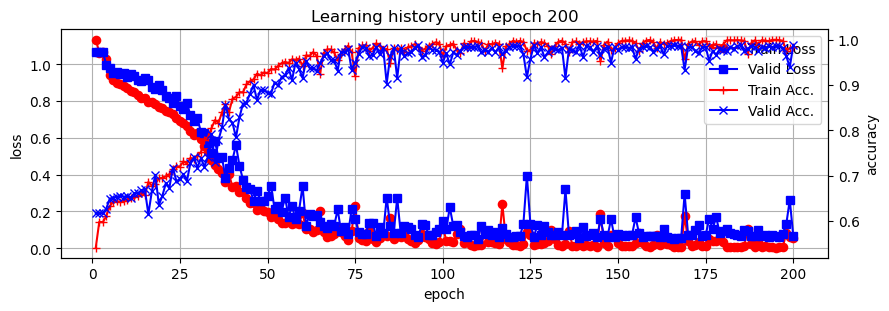

Epoch: 200 | T_Loss 0.054 | T_acc 0.983 | V_Loss 0.066 | V_acc. 0.988 | 🕒 3.256
Epoch: 199 | T_Loss  0.06 | T_acc 0.981 | V_Loss 0.263 | V_acc.  0.94 | 🕒 3.404
Epoch: 198 | T_Loss 0.082 | T_acc 0.976 | V_Loss  0.13 | V_acc. 0.964 | 🕒 3.363
Epoch: 197 | T_Loss 0.006 | T_acc 0.998 | V_Loss  0.08 | V_acc. 0.982 | 🕒 3.313
Epoch: 196 | T_Loss 0.005 | T_acc 0.999 | V_Loss 0.062 | V_acc. 0.986 | 🕒 3.097
Epoch: 195 | T_Loss 0.004 | T_acc   1.0 | V_Loss 0.067 | V_acc. 0.986 | 🕒 3.081
Epoch: 194 | T_Loss 0.005 | T_acc 0.999 | V_Loss 0.074 | V_acc. 0.984 | 🕒  4.52
Epoch: 193 | T_Loss 0.008 | T_acc 0.997 | V_Loss 0.061 | V_acc. 0.986 | 🕒 3.629
Epoch: 192 | T_Loss 0.011 | T_acc 0.998 | V_Loss 0.071 | V_acc. 0.982 | 🕒 3.169
Epoch: 191 | T_Loss 0.009 | T_acc 0.999 | V_Loss 0.069 | V_acc. 0.984 | 🕒 3.061
Epoch: 190 | T_Loss 0.036 | T_acc 0.989 | V_Loss 0.099 | V_acc. 0.976 | 🕒 3.349
Epoch: 189 | T_Loss 0.008 | T_acc 0.998 | V_Loss 0.069 | V_acc. 0.984 | 🕒 3.613
Epoch: 188 | T_Loss 0.022 | T_acc 0.992 

In [214]:
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

In [215]:
test_dataset = SkeletonDataset('/workspace/dataset/validation/')

In [216]:
test_loader = DataLoader(test_dataset, batch_size=8)

In [217]:
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.5074
Test Loss: 4.2118
